In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import datetime
import seaborn

from functools import reduce

# Loading the datasets

In [213]:
dataset_folder_path = '../../data/public_data/raw/fitbit/'
fitbit_data_folders = ('Fitabase Data 3.12.16-4.11.16/', 'Fitabase Data 4.12.16-5.12.16/')

In [214]:
def read_and_filter_datetime(path, date_col_name, date_lower, date_upper, format=None):
    df = pd.read_csv(path)
    df[date_col_name] = pd.to_datetime(df[date_col_name], format=format)
    df = df[(df[date_col_name] >= date_lower) & (df[date_col_name] < date_upper)]    
    return df

In [215]:
# read the datasets into panda dataframes
# convert the datetime columns for each df and filter only the ones within the specified date period
# inclusive for date_lower, exclusive for date_upper
FMT = '%m/%d/%Y %I:%M:%S %p'
def read_datasets(path, date_lower, date_upper):
    daily_activity_df = read_and_filter_datetime(path + 'dailyActivity_merged.csv', 'ActivityDate', date_lower, date_upper)
    heart_rate_df = read_and_filter_datetime(path + 'heartrate_seconds_merged.csv', 'Time', date_lower, date_upper, format=FMT)
    hourly_calories_df = read_and_filter_datetime(path + 'hourlyCalories_merged.csv', 'ActivityHour', date_lower, date_upper, format=FMT)
    hourly_intensities_df = read_and_filter_datetime(path + 'hourlyIntensities_merged.csv', 'ActivityHour', date_lower, date_upper, format=FMT)
    hourly_steps_df = read_and_filter_datetime(path + 'hourlySteps_merged.csv', 'ActivityHour', date_lower, date_upper, format=FMT)
    weight_df = read_and_filter_datetime(path + 'weightLogInfo_merged.csv', 'Date', date_lower, date_upper, format=FMT)
    minute_calories_df = read_and_filter_datetime(path + 'minuteCaloriesNarrow_merged.csv', 'ActivityMinute', date_lower, date_upper, format=FMT)
    minute_intensitie_df = read_and_filter_datetime(path + 'minuteIntensitiesNarrow_merged.csv', 'ActivityMinute', date_lower, date_upper, format=FMT)
    minute_met_df = read_and_filter_datetime(path + 'minuteMETsNarrow_merged.csv', 'ActivityMinute', date_lower, date_upper, format=FMT)
    minute_steps_df = read_and_filter_datetime(path + 'minuteStepsNarrow_merged.csv', 'ActivityMinute', date_lower, date_upper, format=FMT)
    minute_sleep_df = read_and_filter_datetime(path + 'minuteSleep_merged.csv', 'date', date_lower, date_upper, format=FMT)
    
    sleep_df = pd.DataFrame()
    
    # note 3/12 -> 4/11 dataset doesn't have the sleepDay dataset
    if os.path.exists(path + 'sleepDay_merged.csv'):
        sleep_df = read_and_filter_datetime(path + 'sleepDay_merged.csv', 'SleepDay', date_lower, date_upper, format=FMT)

    loaded_dfs = [daily_activity_df, heart_rate_df, hourly_calories_df, hourly_intensities_df, hourly_steps_df, weight_df, 
                  minute_calories_df, minute_intensitie_df, minute_met_df, minute_sleep_df, minute_steps_df, sleep_df]
    
    return loaded_dfs

## Concatenating the two datasets together

In [216]:
fitbit_folder1, fitbit_folder2 = fitbit_data_folders
dfs1 = read_datasets(dataset_folder_path + fitbit_folder1, '2016-03-12', '2016-04-12')
dfs2 = read_datasets(dataset_folder_path + fitbit_folder2, '2016-04-12', '2016-05-13')

combined_dfs = []
for df1, df2, in zip(dfs1, dfs2):
    combined_df = pd.concat([df1, df2])
    combined_df.drop_duplicates(keep=False, inplace=True)
    combined_dfs.append(combined_df)


In [217]:
# specify the dataframes of the concatenated list
daily_activity_df, heart_rate_df, hourly_calories_df, hourly_intensities_df, hourly_steps_df, weight_df, minute_calories_df, minute_intensitie_df, minute_met_df, minute_sleep_df, minute_steps_df, sleep_df = combined_dfs

## Merging hourly and minute datasets

In [218]:
# merge hourly datasets together
hourly_dfs = [hourly_calories_df, hourly_intensities_df, hourly_steps_df]
hourly_df = reduce(lambda  left,right: pd.merge(left,right,on=['Id', 'ActivityHour'],
                                            how='outer'), hourly_dfs)

In [219]:
# merge minute datasets together
activity_minutes_dfs = [minute_calories_df, minute_intensitie_df, minute_met_df, minute_steps_df]
activity_minutes_df = reduce(lambda  left,right: pd.merge(left,right,on=['Id', 'ActivityMinute'],
                                            how='outer'), activity_minutes_dfs)

# Handling nans

In [220]:
daily_activity_df.isna().sum().sum(), heart_rate_df.isna().sum().sum(), sleep_df.isna().sum().sum(), weight_df.isna().sum().sum(), hourly_df.isna().sum().sum(), activity_minutes_df.isna().sum().sum(), minute_sleep_df.isna().sum().sum()

(0, 0, 0, 94, 0, 0, 0)

In [221]:
weight_df.isna().sum()

Id                 0
Date               0
WeightKg           0
WeightPounds       0
Fat               94
BMI                0
IsManualReport     0
LogId              0
dtype: int64

In [222]:
weight_df['Fat'].value_counts()

22.0    2
10.0    1
25.0    1
Name: Fat, dtype: int64

In [223]:
# this feature is unlikely to be useful with only 4 non null readings so removing it:
weight_df.pop('Fat')
weight_df.head()

,Id,Date,WeightKg,WeightPounds,BMI,IsManualReport,LogId
0,1503960366,2016-04-05 23:59:59,53.299999,117.506384,22.969999,True,1459900799000
1,1927972279,2016-04-10 18:33:26,129.600006,285.719105,46.169998,False,1460313206000
2,2347167796,2016-04-03 23:59:59,63.400002,139.773078,24.770000,True,1459727999000
3,2873212765,2016-04-06 23:59:59,56.700001,125.002104,21.450001,True,1459987199000
4,2873212765,2016-04-07 23:59:59,57.200001,126.104416,21.650000,True,1460073599000


In [224]:
daily_activity_df.isna().sum().sum(), heart_rate_df.isna().sum().sum(), sleep_df.isna().sum().sum(), weight_df.isna().sum().sum(), hourly_df.isna().sum().sum(), activity_minutes_df.isna().sum().sum(), minute_sleep_df.isna().sum().sum()

(0, 0, 0, 0, 0, 0, 0)

# Exploring datasets

## Exploring daily activity dataset

In [225]:
daily_activity_df.describe()

,Id,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
count,1.373000e+03,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000,1373.000000
mean,4.782326e+09,7377.375091,5.289031,5.261930,0.128591,1.413146,0.546052,3.238128,0.001733,19.871085,13.603787,188.096140,1001.346686,2294.812090
std,2.381544e+09,5198.133424,3.987341,3.973439,0.695630,2.622729,0.872581,2.104300,0.007800,31.817631,26.581555,113.095058,304.168197,725.526989
min,1.503960e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.320127e+09,3321.000000,2.280000,2.270000,0.000000,0.000000,0.000000,1.730000,0.000000,0.000000,0.000000,117.000000,734.000000,1820.000000
50%,4.445115e+09,7142.000000,5.030000,5.020000,0.000000,0.120000,0.200000,3.280000,0.000000,2.000000,6.000000,196.000000,1062.000000,2129.000000
75%,6.962181e+09,10645.000000,7.570000,7.570000,0.000000,1.860000,0.780000,4.710000,0.000000,30.000000,18.000000,263.000000,1246.000000,2781.000000
max,8.877689e+09,36019.000000,28.030001,28.030001,6.727057,21.920000,6.480000,12.510000,0.110000,210.000000,660.000000,720.000000,1440.000000,4900.000000


In [226]:
corr = daily_activity_df.corr()
corr.style.background_gradient(cmap='coolwarm')

/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_5918/2509186338.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = daily_activity_df.corr()


,Id,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
Id,1.000000,0.176216,0.229289,0.225550,0.180879,0.307236,0.028903,0.023520,-0.017890,0.309831,0.026841,-0.087840,-0.043119,0.377156
TotalSteps,0.176216,1.000000,0.985699,0.984005,0.163672,0.739051,0.516233,0.718937,0.069337,0.677471,0.355235,0.594317,-0.356377,0.580077
TotalDistance,0.229289,0.985699,1.000000,0.997974,0.174186,0.794878,0.482791,0.688126,0.076527,0.691782,0.333902,0.545074,-0.318685,0.629583
TrackerDistance,0.225550,0.984005,0.997974,1.000000,0.130541,0.793945,0.482740,0.685146,0.070198,0.690768,0.334593,0.538211,-0.318737,0.629092
LoggedActivitiesDistance,0.180879,0.163672,0.174186,0.130541,1.000000,0.143368,0.067242,0.130746,0.131043,0.214993,0.152202,0.119018,-0.059571,0.192263
VeryActiveDistance,0.307236,0.739051,0.794878,0.793945,0.143368,1.000000,0.206399,0.192768,0.043071,0.834749,0.163278,0.102493,-0.082111,0.480251
ModeratelyActiveDistance,0.028903,0.516233,0.482791,0.482740,0.067242,0.206399,1.000000,0.263732,0.006607,0.237857,0.696725,0.200293,-0.248159,0.237894
LightActiveDistance,0.023520,0.718937,0.688126,0.685146,0.130746,0.192768,0.263732,1.000000,0.082193,0.193736,0.155282,0.873220,-0.442177,0.443275
SedentaryActiveDistance,-0.017890,0.069337,0.076527,0.070198,0.131043,0.043071,0.006607,0.082193,1.000000,0.013559,-0.014332,0.113244,0.033266,0.057132
VeryActiveMinutes,0.309831,0.677471,0.691782,0.690768,0.214993,0.834749,0.237857,0.193736,0.013559,1.000000,0.231601,0.097679,-0.182602,0.593829


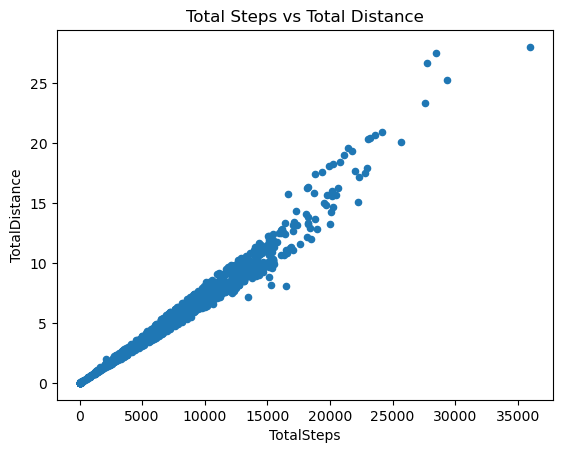

In [227]:
daily_activity_df.sort_values(by=['TotalSteps']).plot(x='TotalSteps', y='TotalDistance', kind='scatter')
plt.title('Total Steps vs Total Distance')
plt.show()

In [228]:
# creating a total activity feature using the values given from the data dictionary
daily_activity_df['TotalActivityMinutes'] = (daily_activity_df['LightlyActiveMinutes']) + (daily_activity_df['FairlyActiveMinutes'] * 2) + (daily_activity_df['VeryActiveMinutes'] * 3)

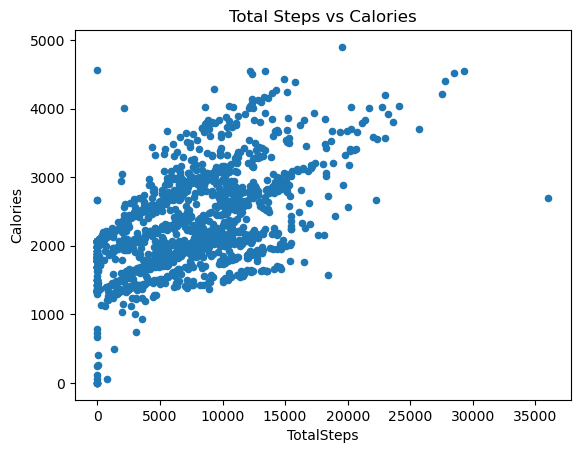

In [229]:
daily_activity_df.sort_values(by=['TotalSteps']).plot(x='TotalSteps', y='Calories', kind='scatter')
plt.title('Total Steps vs Calories')
plt.show()

/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_5918/2981748374.py:6: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (key, group), color in zip(daily_activity_df.groupby(['Id']), colors):


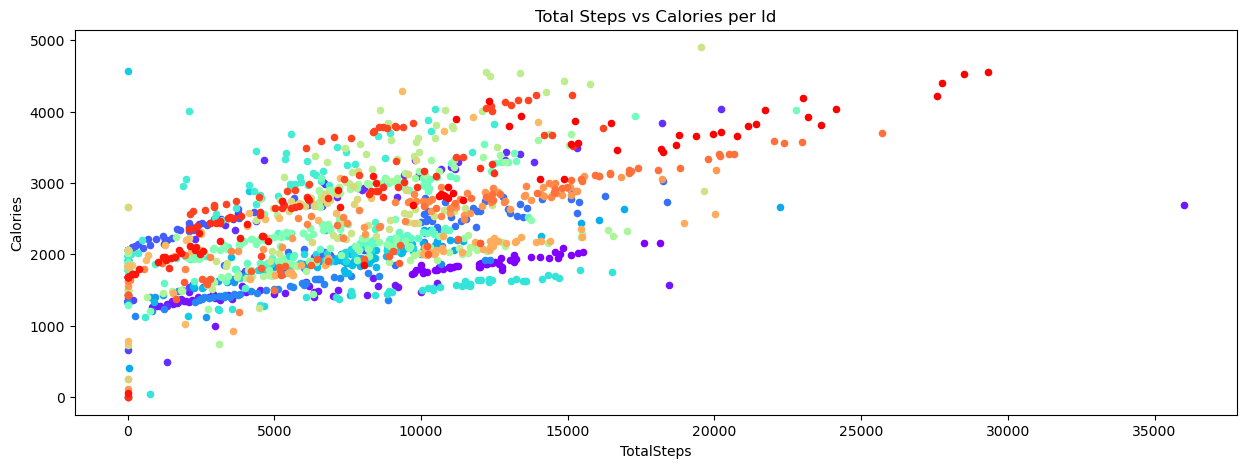

In [230]:
# exploring how different participants' calories vary with their steps
fig, ax = plt.subplots()
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, len(daily_activity_df['Id'].unique())))
for (key, group), color in zip(daily_activity_df.groupby(['Id']), colors):
    ax = group.plot(ax=ax, kind='scatter', x='TotalSteps', y='Calories', label=key, c=np.array([color]), figsize=(15, 5))
    ax.get_legend().remove()

plt.title('Total Steps vs Calories per Id')
plt.ylabel('Calories')
plt.show()

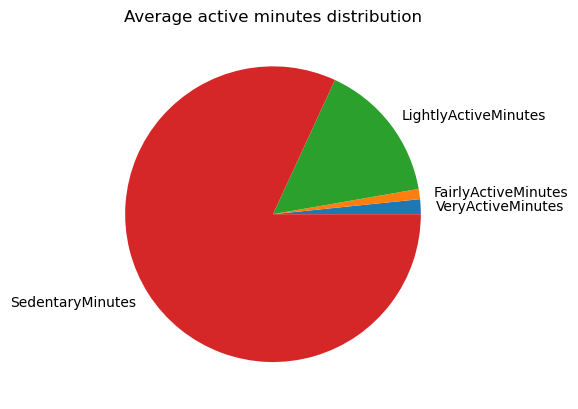

In [231]:
daily_activity_df[['VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes']].mean().plot(kind='pie', subplots=True)
plt.title('Average active minutes distribution')
plt.show()

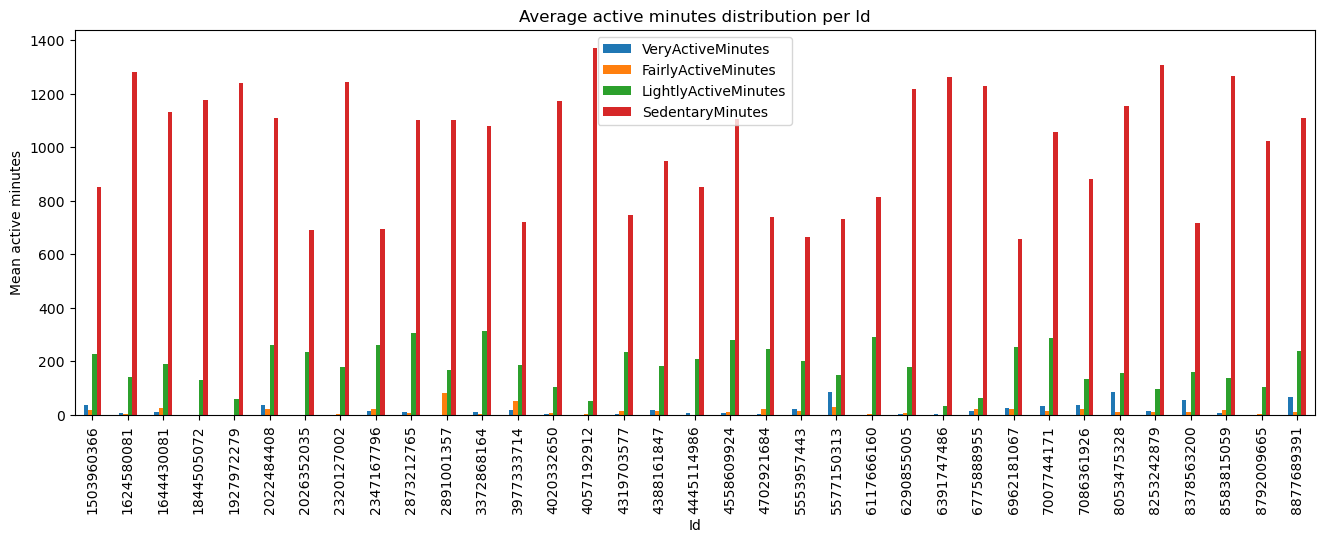

In [232]:
daily_activity_df.groupby('Id')[['VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes']].mean().plot.bar(figsize=(16, 5))
plt.title('Average active minutes distribution per Id')
plt.ylabel('Mean active minutes')
plt.show()

In [233]:
# filter out the full day sedentary recordings
daily_activity_df= daily_activity_df[daily_activity_df['SedentaryMinutes'] < 1440]

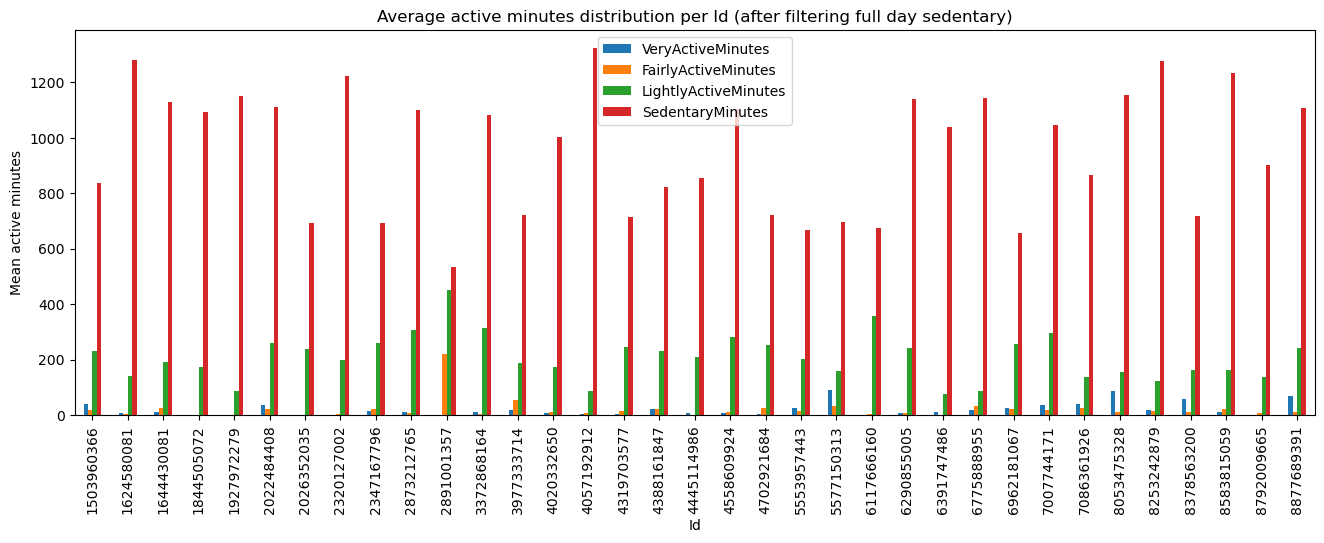

In [234]:
daily_activity_df.groupby('Id')[['VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes']].mean().plot.bar(figsize=(16, 5))
plt.title('Average active minutes distribution per Id (after filtering full day sedentary)')
plt.ylabel('Mean active minutes')
plt.show()

In [235]:
# Comparing sum of hourly values vs daily values for steps:
incorrect_sum_diff = []
total_count = 0
for id, grouped_df in daily_activity_df.groupby('Id'):
    total_steps_from_hourly_sum = hourly_df[hourly_df['Id'] == id].resample('D', on='ActivityHour')['StepTotal'].sum()
    
    for i, row in grouped_df.iterrows():
        day_date = row['ActivityDate']
        total_steps_in_day = row['TotalSteps']
        # some days don't exist in the hourly dataset that are in the daily...
        if day_date in total_steps_from_hourly_sum.index:
            total_count += 1
            total_steps_per_hour_sum = total_steps_from_hourly_sum[day_date]
            if total_steps_in_day != total_steps_per_hour_sum:
                incorrect_sum_diff.append(abs(total_steps_in_day - total_steps_per_hour_sum))

print(len(incorrect_sum_diff)/total_count)


0.1822620016273393


In [236]:
# shows about 18% are inaccurate
# mean and median values for the differences in sum of per hourly steps and daily total steps
np.array(incorrect_sum_diff).mean(), np.median(np.array(incorrect_sum_diff))

(308.05357142857144, 33.0)

In [237]:
daily_activity_df

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,TotalActivityMinutes
0,1503960366,2016-03-25,11004,7.110000,7.110000,0.0,2.57,0.46,4.07,0.00,33,12,205,804,1819,328
1,1503960366,2016-03-26,17609,11.550000,11.550000,0.0,6.92,0.73,3.91,0.00,89,17,274,588,2154,575
2,1503960366,2016-03-27,12736,8.530000,8.530000,0.0,4.66,0.16,3.71,0.00,56,5,268,605,1944,446
3,1503960366,2016-03-28,13231,8.930000,8.930000,0.0,3.19,0.79,4.95,0.00,39,20,224,1080,1932,381
4,1503960366,2016-03-29,12041,7.850000,7.850000,0.0,2.16,1.09,4.61,0.00,28,28,243,763,1886,383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,8877689391,2016-05-08,10686,8.110000,8.110000,0.0,1.08,0.20,6.80,0.00,17,4,245,1174,2847,304
936,8877689391,2016-05-09,20226,18.250000,18.250000,0.0,11.10,0.80,6.24,0.05,73,19,217,1131,3710,474
937,8877689391,2016-05-10,10733,8.150000,8.150000,0.0,1.35,0.46,6.28,0.00,18,11,224,1187,2832,300
938,8877689391,2016-05-11,21420,19.559999,19.559999,0.0,13.22,0.41,5.89,0.00,88,12,213,1127,3832,501


/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_5918/1418298713.py:6: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (key, group), color in zip(daily_activity_df.groupby(['Id']), colors):


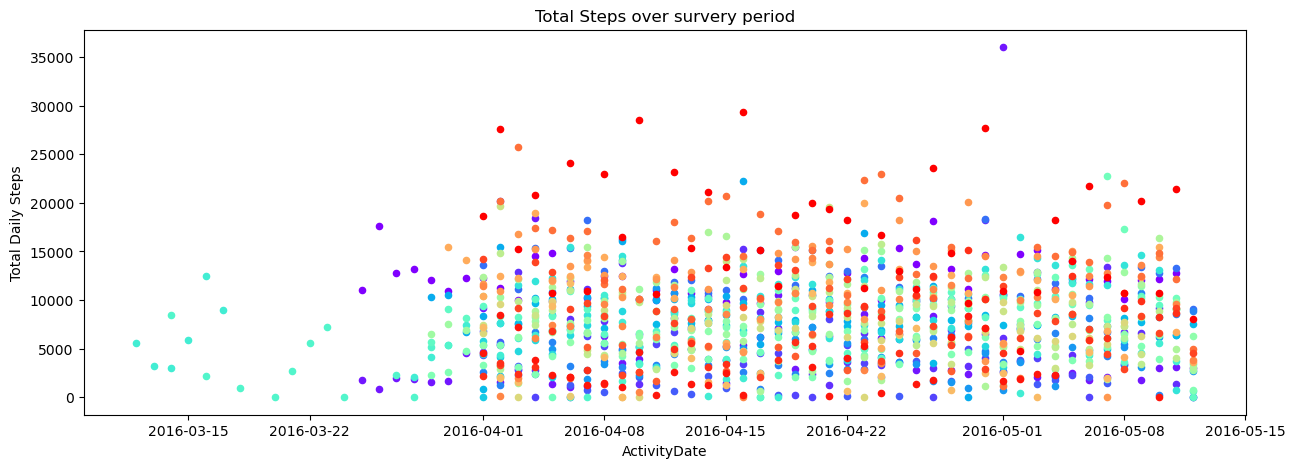

In [238]:
# exploring how different participants' calories vary with their steps
fig, ax = plt.subplots()
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, len(daily_activity_df['Id'].unique())))
for (key, group), color in zip(daily_activity_df.groupby(['Id']), colors):
    ax = group.plot(ax=ax, kind='scatter', x='ActivityDate', y='TotalSteps', label=key, c=np.array([color]), figsize=(15, 5))
    ax.get_legend().remove()

plt.title('Total Steps over survery period')
plt.ylabel('Total Daily Steps')
plt.show()

In [239]:
# ^Note that the start shows not many participants steps were recorded

/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_5918/700489996.py:9: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (key, group), color in zip(id_df.groupby(['Id']), colors):


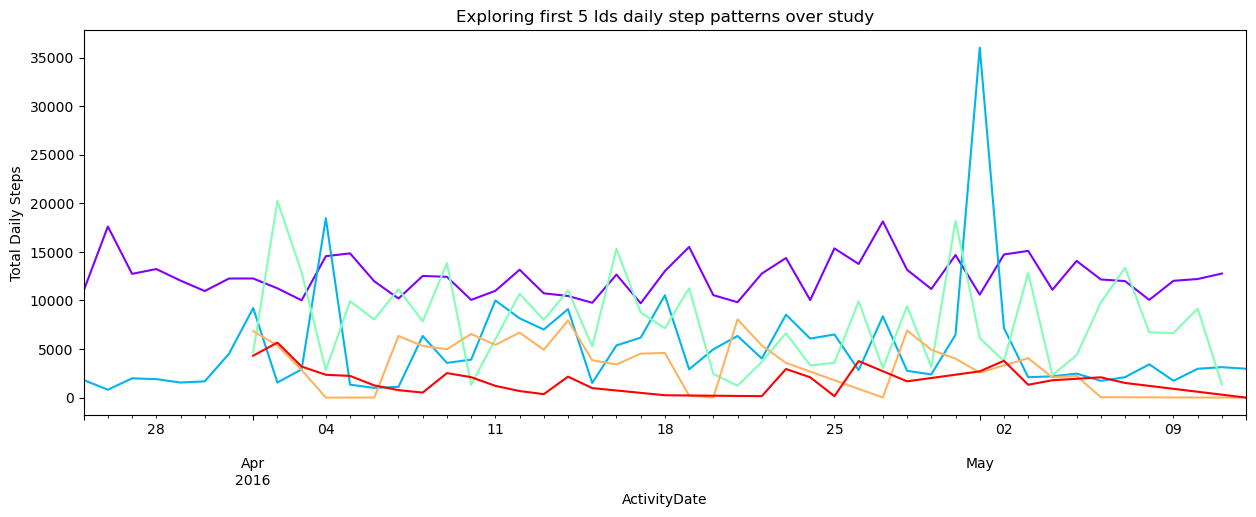

In [240]:
# exploring how different participants' calories vary with their steps
fig, ax = plt.subplots()
import matplotlib.cm as cm

first5Ids = daily_activity_df['Id'].unique()[:5]
id_df = daily_activity_df[daily_activity_df['Id'].isin(first5Ids)]

colors = cm.rainbow(np.linspace(0, 1, len(id_df['Id'].unique())))
for (key, group), color in zip(id_df.groupby(['Id']), colors):
    ax = group.plot(ax=ax, x='ActivityDate', y='TotalSteps', label=key, c=np.array([color]), figsize=(15, 5))
    ax.get_legend().remove()

plt.title('Exploring first 5 Ids daily step patterns over study')
plt.ylabel('Total Daily Steps')
plt.show()

## Exploring activity minutes dataset

In [241]:
activity_minutes_df.describe()

,Id,Calories,Intensity,METs,Steps
count,2.760120e+06,2.760120e+06,2.760120e+06,2.760120e+06,2.760120e+06
mean,4.869781e+09,1.597030e+00,1.903754e-01,1.446218e+01,5.047862e+00
std,2.421117e+09,1.386245e+00,5.065391e-01,1.179921e+01,1.766869e+01
min,1.503960e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.320127e+09,9.357000e-01,0.000000e+00,1.000000e+01,0.000000e+00
50%,4.558610e+09,1.217600e+00,0.000000e+00,1.000000e+01,0.000000e+00
75%,6.962181e+09,1.431000e+00,0.000000e+00,1.100000e+01,0.000000e+00
max,8.877689e+09,2.301264e+01,3.000000e+00,1.890000e+02,2.200000e+02


In [242]:
# Fixing MET values since they are exported by multiplying by 10, so to get accurate values divide by 10
activity_minutes_df['METs'] = activity_minutes_df['METs'] / 10
activity_minutes_df['METs'].describe()

count    2.760120e+06
mean     1.446218e+00
std      1.179921e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.100000e+00
max      1.890000e+01
Name: METs, dtype: float64

In [243]:
corr = activity_minutes_df.corr()
corr.style.background_gradient(cmap='coolwarm')

/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_5918/547813836.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = activity_minutes_df.corr()


,Id,Calories,Intensity,METs,Steps
Id,1.000000,0.129499,0.016884,0.035689,0.025197
Calories,0.129499,1.000000,0.892685,0.957488,0.832456
Intensity,0.016884,0.892685,1.000000,0.938872,0.809806
METs,0.035689,0.957488,0.938872,1.000000,0.888464
Steps,0.025197,0.832456,0.809806,0.888464,1.000000


/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_5918/3650221007.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (key, group), color in zip(activity_minutes_df.groupby(['Id']), colors):


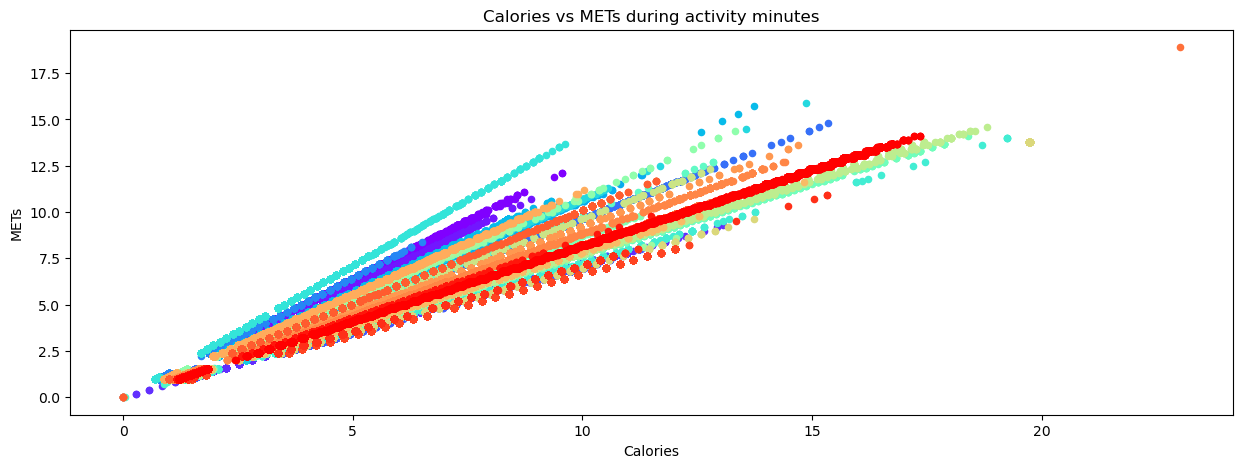

In [244]:
fig, ax = plt.subplots()
colors = cm.rainbow(np.linspace(0, 1, len(activity_minutes_df['Id'].unique())))
for (key, group), color in zip(activity_minutes_df.groupby(['Id']), colors):
    ax = group.plot(ax=ax, kind='scatter', x='Calories', y='METs', label=key, c=np.array([color]), figsize=(15, 5))
    ax.get_legend().remove()
plt.title('Calories vs METs during activity minutes')
plt.show()

In [245]:
# outlier:
activity_minutes_df[activity_minutes_df['Calories'] > 23]

,Id,ActivityMinute,Calories,Intensity,METs,Steps
1182543,8053475328,2016-03-19 14:03:00,23.01264,3,18.9,13


In [246]:
activity_minutes_df['Calories'].describe()

count    2.760120e+06
mean     1.597030e+00
std      1.386245e+00
min      0.000000e+00
25%      9.357000e-01
50%      1.217600e+00
75%      1.431000e+00
max      2.301264e+01
Name: Calories, dtype: float64

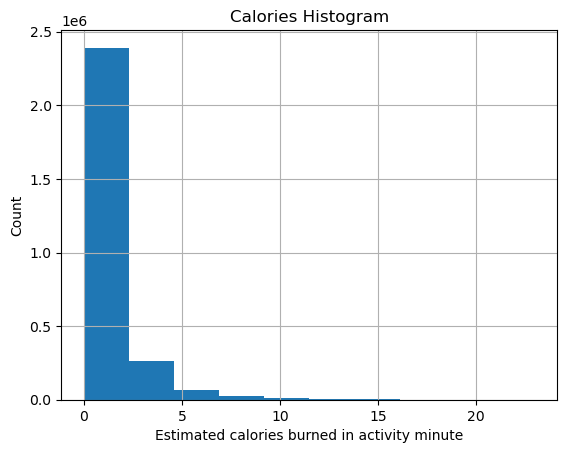

In [247]:
activity_minutes_df['Calories'].hist()
plt.title('Calories Histogram')
plt.xlabel('Estimated calories burned in activity minute')
plt.ylabel('Count')
plt.show()

In [248]:
#^this distribution is skewed
# Getting outliers using the interquantile range:
IQR = activity_minutes_df['Calories'].quantile(0.75) - activity_minutes_df['Calories'].quantile(0.25)
lower = activity_minutes_df['Calories'].quantile(0.25) - (IQR * 3)
upper = activity_minutes_df['Calories'].quantile(0.75) + (IQR * 3)
print(f'Calories outliers from the IQR < {lower} or > {upper}')

Calories outliers from the IQR < -0.5501999855041384 or > 2.9168999791145165


In [249]:
#^^Note: it may be a good idea to remove the outliers of highly skewed variables with the process of 'Discretisation' -> via binning technique if using a model that assumes a normal distribution
# (e.g. logistic regression)

In [250]:
activity_minutes_df.head()

,Id,ActivityMinute,Calories,Intensity,METs,Steps
0,1503960366,2016-03-12 00:00:00,0.7973,0,1.0,0
1,1503960366,2016-03-12 00:01:00,0.7973,0,1.0,0
2,1503960366,2016-03-12 00:02:00,0.7973,0,1.0,0
3,1503960366,2016-03-12 00:03:00,0.7973,0,1.0,0
4,1503960366,2016-03-12 00:04:00,0.7973,0,1.0,0


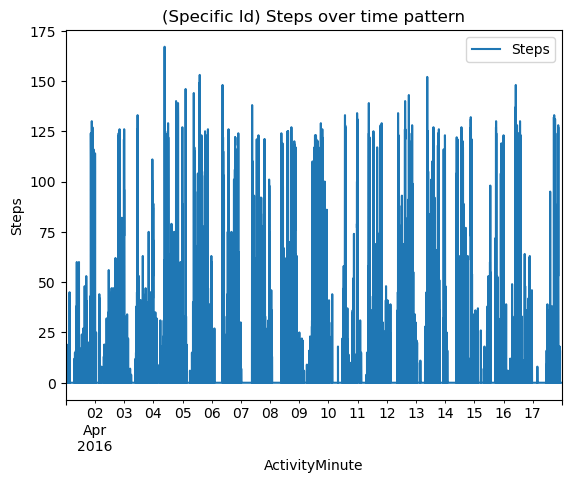

In [251]:
id_df = activity_minutes_df[activity_minutes_df['Id'] == 1503960366]
id_df[(id_df['ActivityMinute'] > '2016-04-01 00:00:00') & (id_df['ActivityMinute'] < '2016-04-18 00:00:00')].plot(x='ActivityMinute', y='Steps')
plt.title('(Specific Id) Steps over time pattern')
plt.ylabel('Steps')
plt.show()

## Exploring heart rate dataset

In [252]:
heart_rate_df.describe()

,Id,Value
count,3.614915e+06,3.614915e+06
mean,5.461442e+09,7.813992e+01
std,1.978372e+09,1.921728e+01
min,2.022484e+09,3.600000e+01
25%,4.020333e+09,6.400000e+01
50%,5.553957e+09,7.400000e+01
75%,6.962181e+09,8.900000e+01
max,8.877689e+09,2.030000e+02


In [253]:
corr = heart_rate_df.corr()
corr.style.background_gradient(cmap='coolwarm')

/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_5918/307043183.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = heart_rate_df.corr()


,Id,Value
Id,1.000000,0.064168
Value,0.064168,1.000000


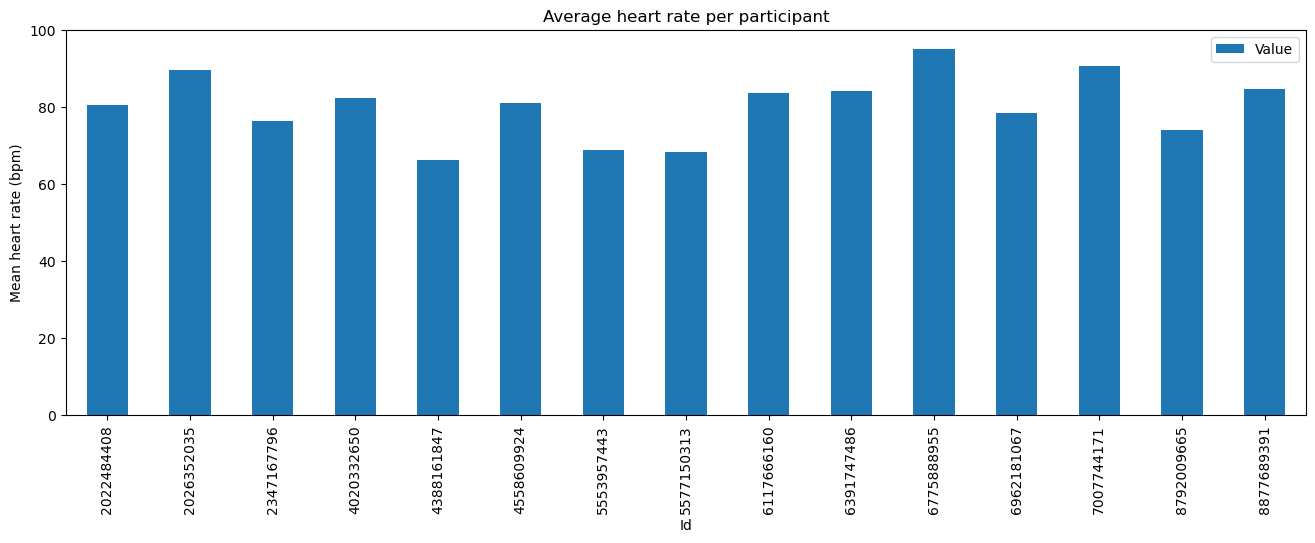

In [254]:
heart_rate_df.groupby('Id')[['Value']].mean().plot.bar(figsize=(16, 5))
plt.title('Average heart rate per participant')
plt.ylabel('Mean heart rate (bpm)')
plt.ylim(0, 100)
plt.show()

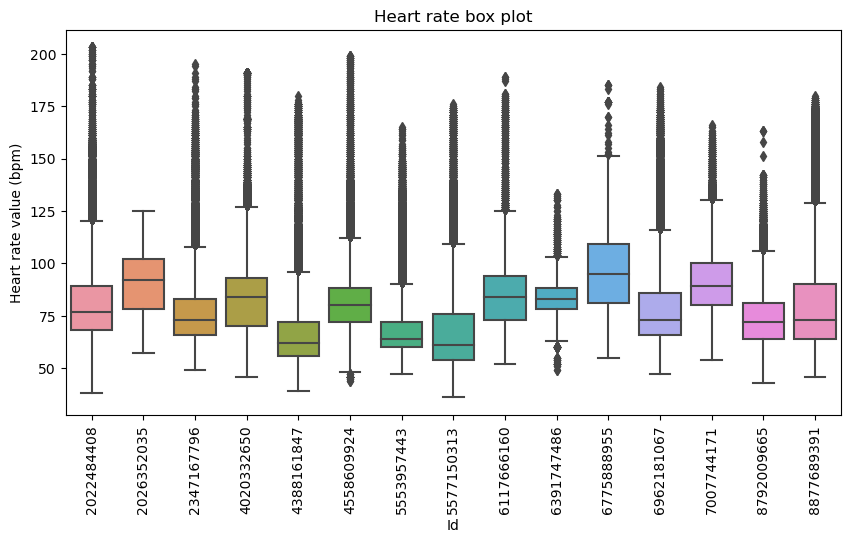

In [255]:
# Heart rate box plot - displays the large number of outliers which likely is when the participant is active
plt.figure(figsize=(10,5))
ax = seaborn.boxplot(x="Id",y="Value",data=heart_rate_df)
plt.ylabel('Heart rate value (bpm)')
plt.title('Heart rate box plot')
plt.xticks(rotation=90)
plt.show()

In [256]:
## create a plot for overlapping 'activity' and 'value'?? since the time? -> activity minute and then resample this by minute? -> should work
heart_rate_mins = pd.DataFrame()
for n, g in heart_rate_df.groupby('Id'):
    df = g.resample('1Min', on='Time')['Value'].mean().to_frame()
    df['Id'] = n
    heart_rate_mins = pd.concat([heart_rate_mins, df])

heart_rate_mins

,Value,Id
Time,,
2016-04-01 07:54:00,99.600000,2022484408
2016-04-01 07:55:00,110.111111,2022484408
2016-04-01 07:56:00,92.555556,2022484408
2016-04-01 07:57:00,90.400000,2022484408
2016-04-01 07:58:00,97.875000,2022484408
...,...,...
2016-05-12 14:40:00,56.222222,8877689391
2016-05-12 14:41:00,57.857143,8877689391
2016-05-12 14:42:00,56.000000,8877689391


In [257]:
heart_rate_activity_mins_merged = heart_rate_mins.merge(activity_minutes_df, left_on=['Id', 'Time'], right_on=['Id', 'ActivityMinute'], how='inner')
heart_rate_activity_mins_merged

,Value,Id,ActivityMinute,Calories,Intensity,METs,Steps
0,99.600000,2022484408,2016-04-01 07:54:00,3.73572,1,3.6,22
1,110.111111,2022484408,2016-04-01 07:55:00,4.15080,1,4.0,10
2,92.555556,2022484408,2016-04-01 07:56:00,5.18850,1,5.0,27
3,90.400000,2022484408,2016-04-01 07:57:00,1.34901,0,1.3,0
4,97.875000,2022484408,2016-04-01 07:58:00,3.32064,1,3.2,17
...,...,...,...,...,...,...,...
765188,60.666667,8877689391,2016-05-12 13:55:00,1.33353,0,1.1,0
765189,61.875000,8877689391,2016-05-12 13:56:00,1.33353,0,1.1,0
765190,58.142857,8877689391,2016-05-12 13:57:00,1.33353,0,1.1,0
765191,61.200000,8877689391,2016-05-12 13:58:00,1.33353,0,1.1,0


In [258]:
corr = heart_rate_activity_mins_merged.corr()
corr.style.background_gradient(cmap='coolwarm')

/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_5918/2989215530.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = heart_rate_activity_mins_merged.corr()


,Value,Id,Calories,Intensity,METs,Steps
Value,1.000000,0.033830,0.713206,0.683698,0.747045,0.599516
Id,0.033830,1.000000,0.086000,0.007812,0.028487,0.023217
Calories,0.713206,0.086000,1.000000,0.898303,0.975738,0.829897
Intensity,0.683698,0.007812,0.898303,1.000000,0.938152,0.803119
METs,0.747045,0.028487,0.975738,0.938152,1.000000,0.873507
Steps,0.599516,0.023217,0.829897,0.803119,0.873507,1.000000


/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_5918/3232693409.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (key, group), color in zip(heart_rate_activity_mins_merged.groupby(['Id']), colors):


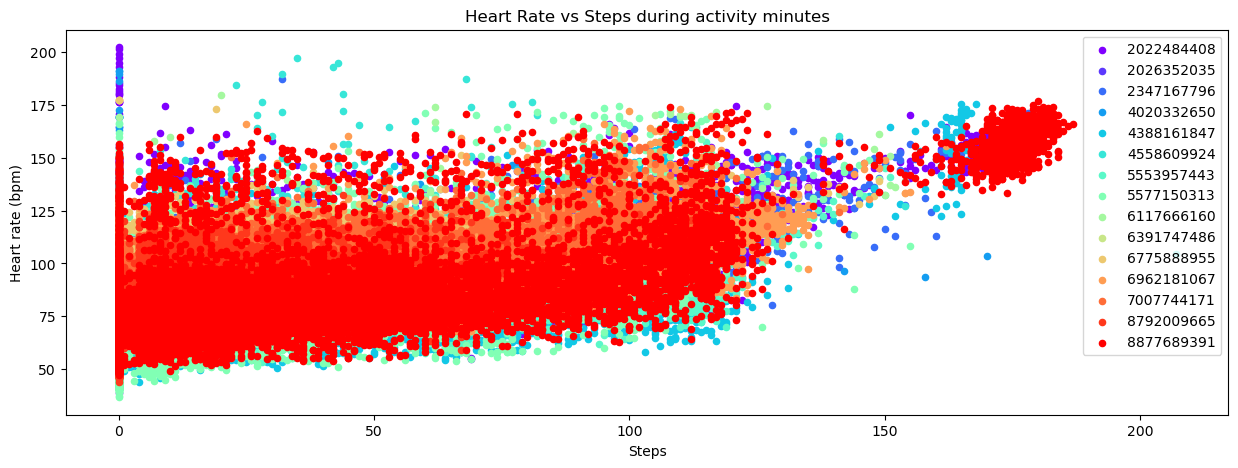

In [259]:
fig, ax = plt.subplots()
colors = cm.rainbow(np.linspace(0, 1, len(heart_rate_activity_mins_merged['Id'].unique())))
for (key, group), color in zip(heart_rate_activity_mins_merged.groupby(['Id']), colors):
    ax = group.plot(ax=ax, kind='scatter', x='Steps', y='Value', label=key, c=np.array([color]), figsize=(15, 5))
    # ax.get_legend().remove()
plt.ylabel('Heart rate (bpm)')
plt.title('Heart Rate vs Steps during activity minutes')
plt.show()

/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_5918/1512707575.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (key, group), color in zip(heart_rate_activity_mins_merged.groupby(['Id']), colors):


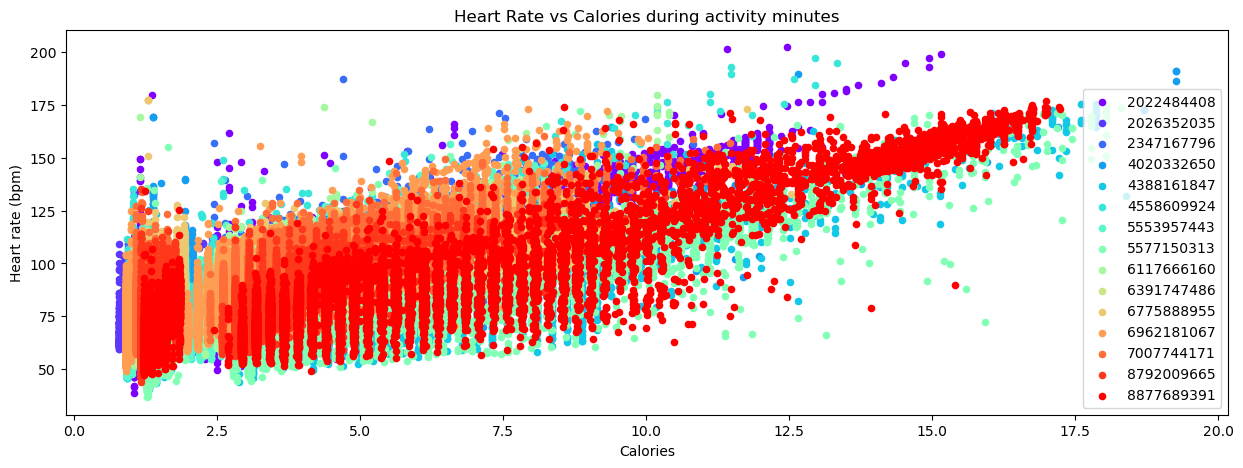

In [260]:
fig, ax = plt.subplots()
colors = cm.rainbow(np.linspace(0, 1, len(heart_rate_activity_mins_merged['Id'].unique())))
for (key, group), color in zip(heart_rate_activity_mins_merged.groupby(['Id']), colors):
    ax = group.plot(ax=ax, kind='scatter', x='Calories', y='Value', label=key, c=np.array([color]), figsize=(15, 5))
    # ax.get_legend().remove()
plt.ylabel('Heart rate (bpm)')
plt.title('Heart Rate vs Calories during activity minutes')
plt.show()

/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_5918/514552228.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (key, group), color in zip(heart_rate_activity_mins_merged.groupby(['Id']), colors):


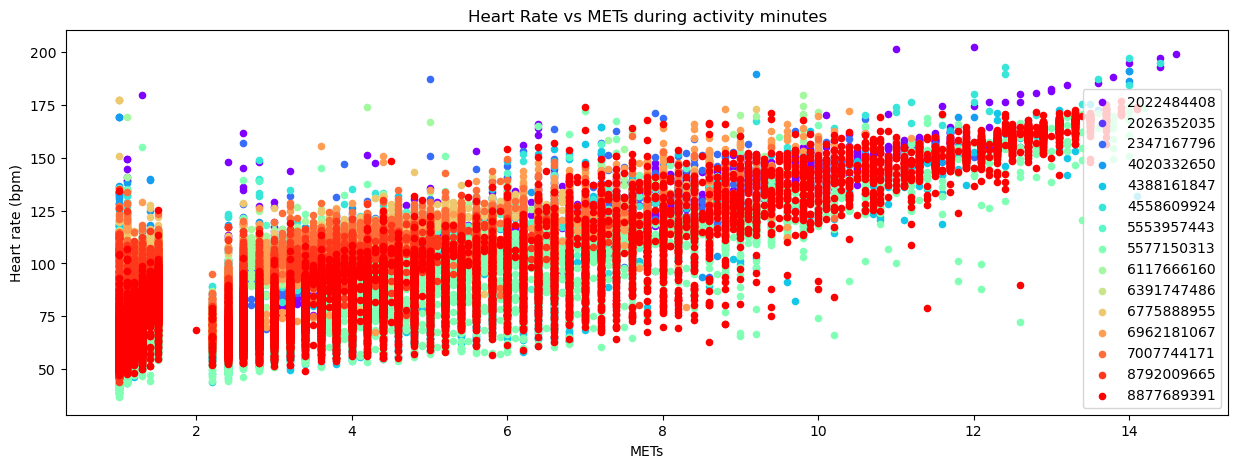

In [261]:
fig, ax = plt.subplots()
colors = cm.rainbow(np.linspace(0, 1, len(heart_rate_activity_mins_merged['Id'].unique())))
for (key, group), color in zip(heart_rate_activity_mins_merged.groupby(['Id']), colors):
    ax = group.plot(ax=ax, kind='scatter', x='METs', y='Value', label=key, c=np.array([color]), figsize=(15, 5))
    # ax.get_legend().remove()
plt.ylabel('Heart rate (bpm)')
plt.title('Heart Rate vs METs during activity minutes')
plt.show()

In [262]:
# ^Note that this gap is due to the inner merge cutting off times that don't exist for both datasets

## Exploring hourly dataset

In [263]:
hourly_df.describe()

,Id,Calories,TotalIntensity,AverageIntensity,StepTotal
count,4.600800e+04,46008.000000,46008.000000,46008.000000,46008.000000
mean,4.869940e+09,95.815771,11.422470,0.190375,302.871501
std,2.421206e+09,60.041219,20.716827,0.345280,677.298581
min,1.503960e+09,42.000000,0.000000,0.000000,0.000000
25%,2.320127e+09,62.000000,0.000000,0.000000,0.000000
50%,4.558610e+09,80.000000,2.000000,0.033333,21.000000
75%,6.962181e+09,106.000000,15.000000,0.250000,323.000000
max,8.877689e+09,948.000000,180.000000,3.000000,10565.000000


In [264]:
corr = hourly_df.corr()
corr.style.background_gradient(cmap='coolwarm')

/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_5918/3876924784.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = hourly_df.corr()


,Id,Calories,TotalIntensity,AverageIntensity,StepTotal
Id,1.000000,0.179386,0.024730,0.024730,0.039424
Calories,0.179386,1.000000,0.901278,0.901278,0.821693
TotalIntensity,0.024730,0.901278,1.000000,1.000000,0.898809
AverageIntensity,0.024730,0.901278,1.000000,1.000000,0.898809
StepTotal,0.039424,0.821693,0.898809,0.898809,1.000000


/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_5918/3026992737.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (key, group), color in zip(hourly_df.groupby(['Id']), colors):


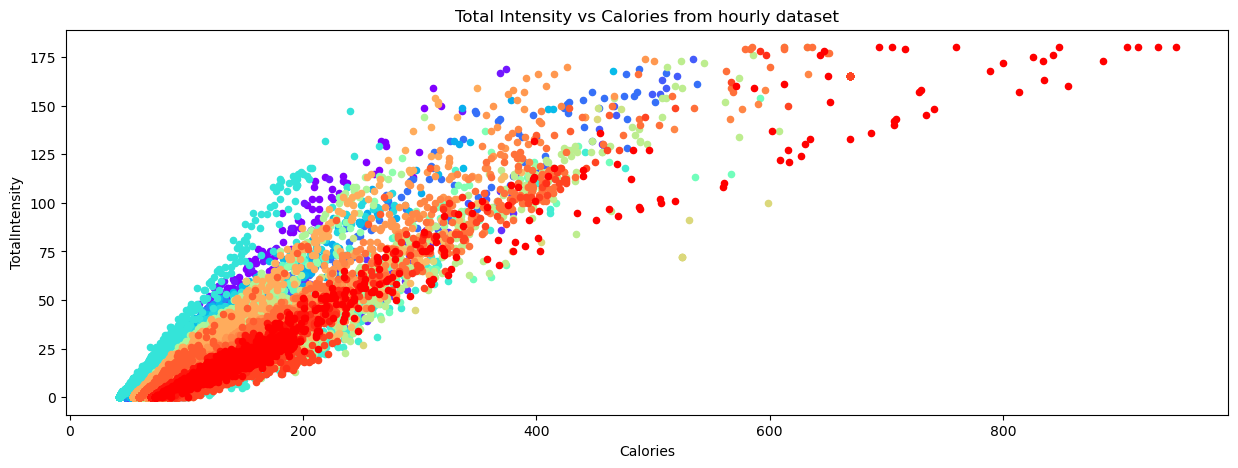

In [265]:
fig, ax = plt.subplots()
colors = cm.rainbow(np.linspace(0, 1, len(hourly_df['Id'].unique())))
for (key, group), color in zip(hourly_df.groupby(['Id']), colors):
    ax = group.plot(ax=ax, kind='scatter', x='Calories', y='TotalIntensity', label=key, c=np.array([color]), figsize=(15, 5))
    ax.get_legend().remove()
plt.title('Total Intensity vs Calories from hourly dataset')
plt.show()

In [266]:
# Note: zero total intensity still burns calories - could be due to Fitbit calculations from the participant's input at the start
hourly_df[hourly_df['TotalIntensity'] == 0].describe()

,Id,Calories,TotalIntensity,AverageIntensity,StepTotal
count,2.002700e+04,20027.000000,20027.0,20027.0,20027.000000
mean,4.986171e+09,67.666300,0.0,0.0,0.000399
std,2.452761e+09,12.959237,0.0,0.0,0.056530
min,1.503960e+09,42.000000,0.0,0.0,0.000000
25%,2.320127e+09,56.000000,0.0,0.0,0.000000
50%,4.558610e+09,68.000000,0.0,0.0,0.000000
75%,7.007744e+09,78.000000,0.0,0.0,0.000000
max,8.877689e+09,106.000000,0.0,0.0,8.000000


/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_5918/324431200.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (key, group), color in zip(hourly_df.groupby(['Id']), colors):


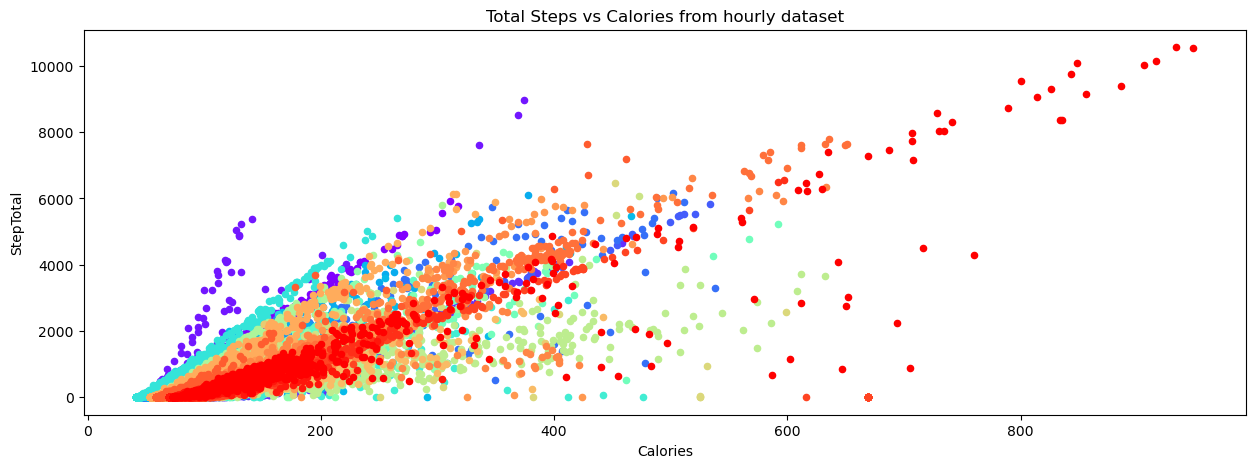

In [267]:
fig, ax = plt.subplots()
colors = cm.rainbow(np.linspace(0, 1, len(hourly_df['Id'].unique())))
for (key, group), color in zip(hourly_df.groupby(['Id']), colors):
    ax = group.plot(ax=ax, kind='scatter', x='Calories', y='StepTotal', label=key, c=np.array([color]), figsize=(15, 5))
    ax.get_legend().remove()
plt.title('Total Steps vs Calories from hourly dataset')
plt.show()

In [268]:
# add total hourly sleeps to hourly dataset
minute_sleep_df.head()

,Id,date,value,logId
0,1503960366,2016-03-13 02:39:30,1,11114919637
1,1503960366,2016-03-13 02:40:30,1,11114919637
2,1503960366,2016-03-13 02:41:30,1,11114919637
3,1503960366,2016-03-13 02:42:30,1,11114919637
4,1503960366,2016-03-13 02:43:30,1,11114919637


In [269]:


# resample to minute heart rate values from 15-20s
def get_total_hourly_vals(group):
    # value == 1 is 'asleep'
    # if mean sleep values are closer to 1 then assume that hour counts as sleeping
    total_hourly_values = group.resample('60min', on='date')['value'].mean()
    return total_hourly_values.to_frame()
    
sleep_per_hour_df = minute_sleep_df.groupby('Id').apply(get_total_hourly_vals)
sleep_per_hour_df.head(20)

value
Id         date                         
1503960366 2016-03-13 02:00:00  1.190476
           2016-03-13 03:00:00  1.000000
           2016-03-13 04:00:00  1.033333
           2016-03-13 05:00:00  1.000000
           2016-03-13 06:00:00  1.016667
           2016-03-13 07:00:00  1.050000
           2016-03-13 08:00:00  1.050000
           2016-03-13 09:00:00  1.044444
           2016-03-13 10:00:00       NaN
           2016-03-13 11:00:00       NaN
           2016-03-13 12:00:00       NaN
           2016-03-13 13:00:00       NaN
           2016-03-13 14:00:00       NaN
           2016-03-13 15:00:00       NaN
           2016-03-13 16:00:00       NaN
           2016-03-13 17:00:00       NaN
           2016-03-13 18:00:00       NaN
           2016-03-13 19:00:00       NaN
           2016-03-13 20:00:00       NaN
           2016-03-13 21:00:00       NaN

In [270]:

sleep_per_hour_df['isAsleep'] = np.where(sleep_per_hour_df['value'] < 1.5, 1, 0)
sleep_per_hour_df = sleep_per_hour_df.reset_index()
sleep_per_hour_df.head(50)

,Id,date,value,isAsleep
0,1503960366,2016-03-13 02:00:00,1.190476,1
1,1503960366,2016-03-13 03:00:00,1.000000,1
2,1503960366,2016-03-13 04:00:00,1.033333,1
3,1503960366,2016-03-13 05:00:00,1.000000,1
4,1503960366,2016-03-13 06:00:00,1.016667,1
5,1503960366,2016-03-13 07:00:00,1.050000,1
6,1503960366,2016-03-13 08:00:00,1.050000,1
7,1503960366,2016-03-13 09:00:00,1.044444,1
8,1503960366,2016-03-13 10:00:00,NaN,0
9,1503960366,2016-03-13 11:00:00,NaN,0


In [271]:
sleep_per_hour_df.drop(columns=['value'], inplace=True)
sleep_per_hour_df.head()

,Id,date,isAsleep
0,1503960366,2016-03-13 02:00:00,1
1,1503960366,2016-03-13 03:00:00,1
2,1503960366,2016-03-13 04:00:00,1
3,1503960366,2016-03-13 05:00:00,1
4,1503960366,2016-03-13 06:00:00,1


In [272]:
# TODO: join the results to the hourly dataset
hourly_df = hourly_df.merge(sleep_per_hour_df, left_on=['Id', 'ActivityHour'], right_on=['Id', 'date'], how='left')
hourly_df.head()

,Id,ActivityHour,Calories,TotalIntensity,AverageIntensity,StepTotal,date,isAsleep
0,1503960366,2016-03-12 00:00:00,48,0,0.0,0,NaT,NaN
1,1503960366,2016-03-12 01:00:00,48,0,0.0,0,NaT,NaN
2,1503960366,2016-03-12 02:00:00,48,0,0.0,0,NaT,NaN
3,1503960366,2016-03-12 03:00:00,48,0,0.0,0,NaT,NaN
4,1503960366,2016-03-12 04:00:00,48,0,0.0,0,NaT,NaN


In [273]:
hourly_df = hourly_df.drop(columns=['date'])

In [274]:
hourly_df[~hourly_df['isAsleep'].isna()]

,Id,ActivityHour,Calories,TotalIntensity,AverageIntensity,StepTotal,isAsleep
26,1503960366,2016-03-13 02:00:00,50,1,0.016667,27,1.0
27,1503960366,2016-03-13 03:00:00,48,0,0.000000,0,1.0
28,1503960366,2016-03-13 04:00:00,48,0,0.000000,0,1.0
29,1503960366,2016-03-13 05:00:00,48,0,0.000000,0,1.0
30,1503960366,2016-03-13 06:00:00,48,0,0.000000,0,1.0
...,...,...,...,...,...,...,...
45135,8792009665,2016-05-04 06:00:00,72,0,0.000000,0,1.0
45136,8792009665,2016-05-04 07:00:00,73,0,0.000000,0,1.0
45137,8792009665,2016-05-04 08:00:00,72,0,0.000000,0,1.0
45138,8792009665,2016-05-04 09:00:00,78,2,0.033333,31,1.0


## Exploring sleep day dataset

In [275]:
sleep_df.describe()

,Id,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
count,4.070000e+02,407.000000,407.000000,407.000000
mean,4.988858e+09,1.120393,418.874693,458.324324
std,2.061356e+09,0.347761,118.929985,127.812702
min,1.503960e+09,1.000000,58.000000,61.000000
25%,3.977334e+09,1.000000,361.000000,404.500000
50%,4.702922e+09,1.000000,432.000000,463.000000
75%,6.962181e+09,1.000000,490.000000,526.000000
max,8.792010e+09,3.000000,796.000000,961.000000


In [276]:
corr = sleep_df.corr()
corr.style.background_gradient(cmap='coolwarm')

/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_5918/3437060215.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = sleep_df.corr()


,Id,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
Id,1.000000,-0.010609,0.084205,0.006579
TotalSleepRecords,-0.010609,1.000000,0.168185,0.174227
TotalMinutesAsleep,0.084205,0.168185,1.000000,0.930388
TotalTimeInBed,0.006579,0.174227,0.930388,1.000000


/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_5918/19167808.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (key, group), color in zip(sleep_df.groupby(['Id']), colors):


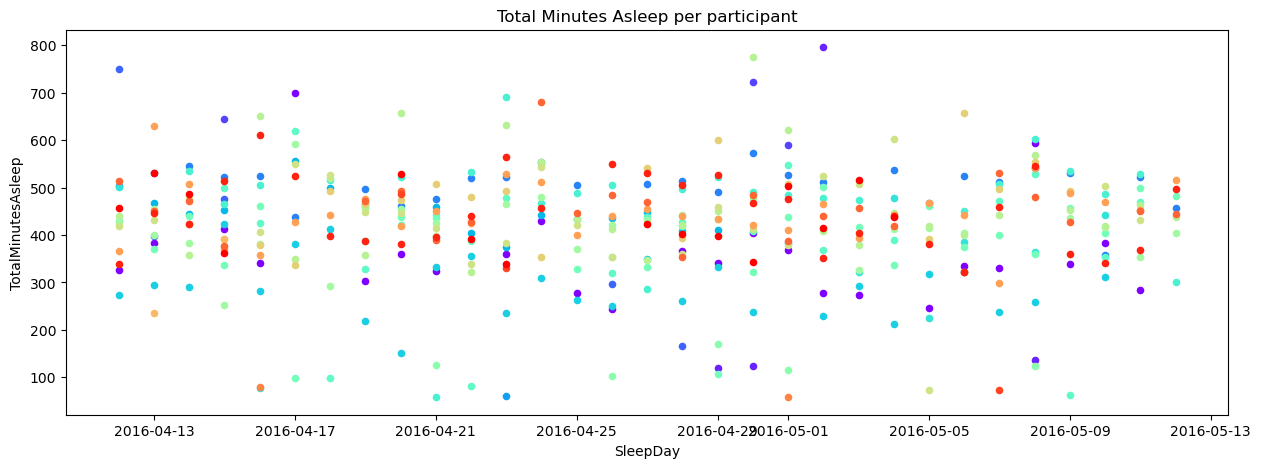

In [277]:
fig, ax = plt.subplots()
colors = cm.rainbow(np.linspace(0, 1, len(sleep_df['Id'].unique())))
for (key, group), color in zip(sleep_df.groupby(['Id']), colors):
    ax = group.plot(ax=ax, kind='scatter', x='SleepDay', y='TotalMinutesAsleep', label=key, c=np.array([color]), figsize=(15, 5))
    ax.get_legend().remove()
plt.title('Total Minutes Asleep per participant')
plt.show()

## Exploring weight dataset

In [278]:
weight_df.describe()

,Id,WeightKg,WeightPounds,BMI,LogId
count,9.800000e+01,98.000000,98.000000,98.000000,9.800000e+01
mean,6.811512e+09,72.466327,159.760904,25.372041,1.461188e+12
std,2.089879e+09,14.820618,32.673870,3.555762,1.089461e+09
min,1.503960e+09,52.599998,115.963147,21.450001,1.459382e+12
25%,6.962181e+09,61.500000,135.584291,24.000000,1.460167e+12
50%,6.962181e+09,62.500000,137.788914,24.389999,1.461123e+12
75%,8.877689e+09,85.250002,187.944083,25.590000,1.462147e+12
max,8.877689e+09,133.500000,294.317120,47.540001,1.463098e+12


In [279]:
corr = weight_df.corr()
corr.style.background_gradient(cmap='coolwarm')

/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_5918/4228573346.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = weight_df.corr()


,Id,WeightKg,WeightPounds,BMI,IsManualReport,LogId
Id,1.000000,0.217166,0.217166,-0.219666,-0.564522,0.083320
WeightKg,0.217166,1.000000,1.000000,0.754520,-0.790000,-0.127955
WeightPounds,0.217166,1.000000,1.000000,0.754520,-0.790000,-0.127955
BMI,-0.219666,0.754520,0.754520,1.000000,-0.305803,-0.149926
IsManualReport,-0.564522,-0.790000,-0.790000,-0.305803,1.000000,-0.016036
LogId,0.083320,-0.127955,-0.127955,-0.149926,-0.016036,1.000000


/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_5918/3814525750.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (key, group), color in zip(weight_df.groupby(['Id']), colors):


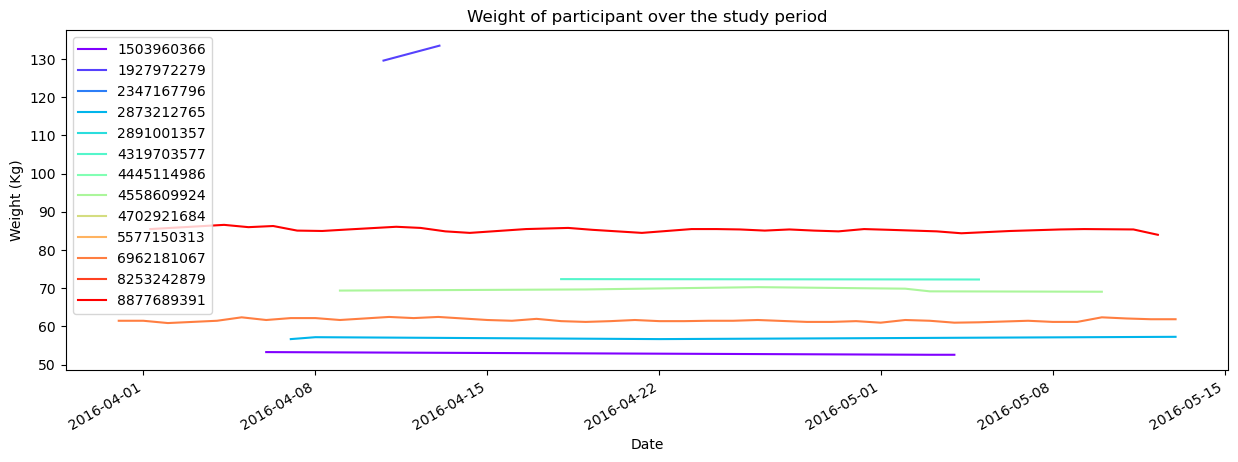

In [280]:
fig, ax = plt.subplots()
colors = cm.rainbow(np.linspace(0, 1, len(weight_df['Id'].unique())))
for (key, group), color in zip(weight_df.groupby(['Id']), colors):
    ax = group.plot(ax=ax, x='Date', y='WeightKg', label=key, c=np.array([color]), figsize=(15, 5))
    # ax.get_legend().remove()
plt.title('Weight of participant over the study period')
plt.ylabel('Weight (Kg)')
plt.show()

In [281]:
#^Few participants and data is faily flat. Could compare the slight changes with activity but any model is likely biased to this 

## Exploring sleep minutes dataset

In [282]:
minute_sleep_df.describe()

,Id,value,logId
count,3.805460e+05,380546.000000,3.805460e+05
mean,4.910620e+09,1.091132,1.136554e+10
std,2.128288e+09,0.322094,1.476616e+08
min,1.503960e+09,1.000000,1.110365e+10
25%,3.977334e+09,1.000000,1.124221e+10
50%,4.702922e+09,1.000000,1.136524e+10
75%,6.775889e+09,1.000000,1.149814e+10
max,8.792010e+09,3.000000,1.161625e+10


In [283]:
corr = minute_sleep_df.corr()
corr.style.background_gradient(cmap='coolwarm')

/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_5918/3054784652.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = minute_sleep_df.corr()


,Id,value,logId
Id,1.000000,-0.058099,0.048894
value,-0.058099,1.000000,0.023524
logId,0.048894,0.023524,1.000000


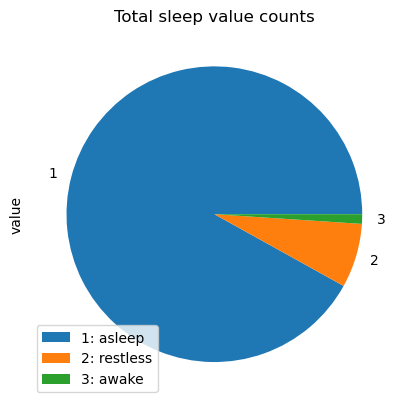

In [284]:
minute_sleep_df[['value']].apply(pd.value_counts).plot(kind='pie', subplots=True)
plt.title('Total sleep value counts')
plt.legend(labels=['1: asleep', '2: restless', '3: awake'])
plt.show()

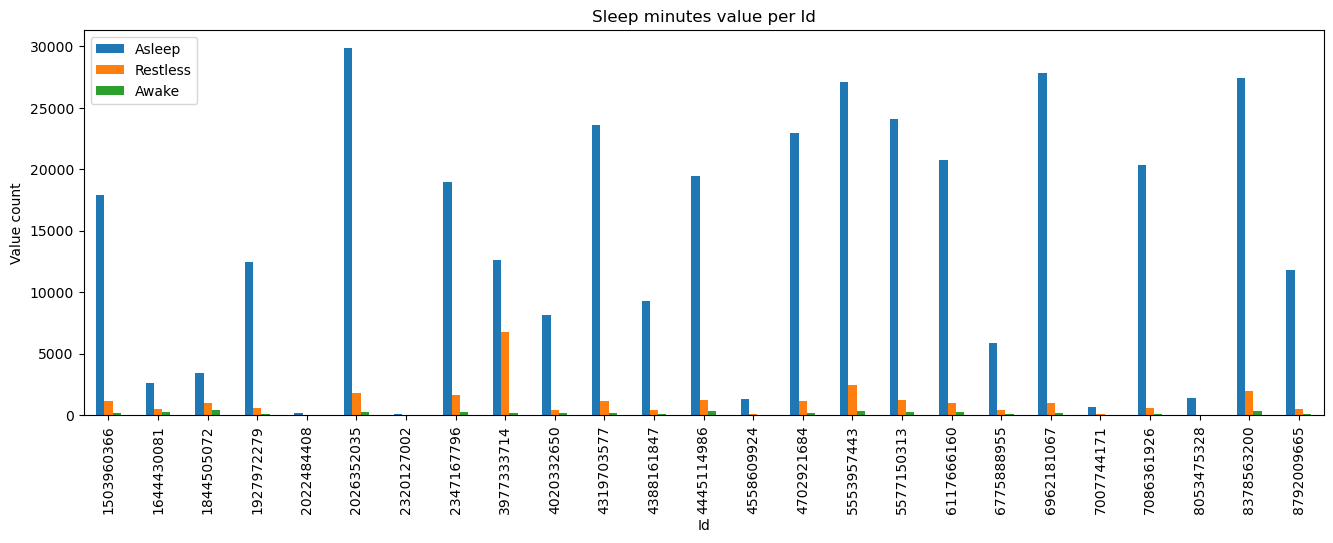

In [285]:
minute_sleep_df.groupby('Id')['value'].value_counts().unstack().plot.bar(figsize=(16, 5))
plt.title('Sleep minutes value per Id')
plt.ylabel('Value count')
plt.legend(labels=['Asleep', 'Restless', 'Awake'])
plt.show()

## Ids per dataset

In [286]:
dfs = {'daily activity': daily_activity_df, 'heart rate': heart_rate_df, 'sleep': sleep_df, 'weight': weight_df, 'hourly': hourly_df, 'activity minutes': activity_minutes_df, 'sleep minutes': minute_sleep_df}
datetime_cols = {'daily activity': 'ActivityDate', 'heart rate': 'Time', 'sleep': 'SleepDay', 'weight': 'Date', 'hourly': 'ActivityHour', 'activity minutes': 'ActivityMinute', 'sleep minutes': 'date'}


In [287]:
print('Ids per dataset:\n')
for name, df in dfs.items():
    ids_in_df = len(df['Id'].unique())
    print(f'{name}: {ids_in_df}')

Ids per dataset:

daily activity: 35
heart rate: 15
sleep: 24
weight: 13
hourly: 35
activity minutes: 35
sleep minutes: 25


## Exploring number of days of data collection for the datasets

In [288]:
from collections import defaultdict

days_of_data = defaultdict(list)
days_of_data['datasets'] = list(dfs.keys())

def number_of_days_of_recorded_data(df, df_name, datetime_col_name):
    unique_record_days = pd.to_datetime(df[datetime_col_name]).dt.date.unique()
    days_of_data['total'].append(len(unique_record_days))

    recorded_days_count = np.array([len(pd.to_datetime(grouped_df[datetime_col_name]).dt.date.unique()) for id, grouped_df in df.groupby('Id')])
    mean_duration_window, std_of_windows = recorded_days_count.mean(), recorded_days_count.std()
    
    days_of_data['mean'].append(mean_duration_window)
    days_of_data['std'].append(std_of_windows)

In [289]:
for name, df in dfs.items():
    number_of_days_of_recorded_data(df, name, datetime_cols[name])

In [290]:
days_of_data_df = pd.DataFrame(days_of_data)
days_of_data_df

,datasets,total,mean,std
0,daily activity,61,35.257143,10.338120
1,heart rate,45,31.266667,12.217292
2,sleep,31,16.958333,11.032071
3,weight,44,7.538462,13.036135
4,hourly,62,55.285714,12.751631
5,activity minutes,62,55.285714,12.751631
6,sleep minutes,62,35.600000,21.708984


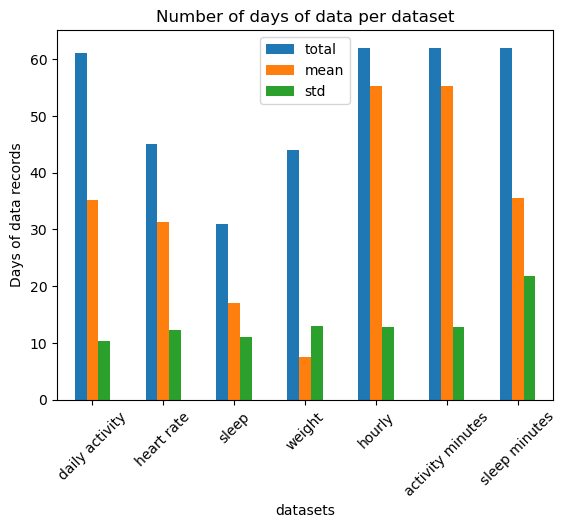

In [291]:
days_of_data_df.plot(x='datasets', y=['total', 'mean', 'std'], kind='bar')
plt.title('Number of days of data per dataset')
plt.ylabel('Days of data records')
plt.xticks(rotation=45)
plt.show()

# Save preprocessed datasets

In [292]:
save_folder_path = '../../data/public_data/cleaned/fitbit/'
daily_activity_df.to_csv(save_folder_path + '/cleaned_daily_activity.csv', index=False)
activity_minutes_df.to_csv(save_folder_path + '/cleaned_activity_minutes.csv', index=False)
heart_rate_df.to_csv(save_folder_path + '/cleaned_heart_rate.csv', index=False)
hourly_df.to_csv(save_folder_path + '/cleaned_hourly.csv', index=False)
sleep_df.to_csv(save_folder_path + '/cleaned_sleep.csv', index=False)
weight_df.to_csv(save_folder_path + '/cleaned_weight.csv', index=False)
minute_sleep_df.to_csv(save_folder_path + '/cleaned_minute_sleep.csv', index=False)
